# Pairwise Maximum Likelihood

Haziq Jamil

In [ ]:
#| include: false
here::i_am("notebooks/pml.qmd")

here() starts at /Users/haziqj/github_local/ligof-tests

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is lavaan 0.6-19
lavaan is FREE software! Please report any bugs.

Rows: 1,000
Columns: 5
$ y1 <ord> 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2…
$ y2 <ord> 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2…
$ y3 <ord> 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1…
$ y4 <ord> 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2…
$ y5 <ord> 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2…
 num [1:15] 1.11e-16 -2.22e-16 0.00 0.00 0.00 ...

We can use the `estimator = "PML"` argument in `{lavaan}` to fit a model using pairwise maximum likelihood (PML) estimation.

In [ ]:
fit <- cfa("f1 =~ y1 + y2 + y3 + y4 + y5", data = dat, estimator = "PML", 
           std.lv = TRUE)
coef(fit)

f1=~y1 f1=~y2 f1=~y3 f1=~y4 f1=~y5  y1|t1  y2|t1  y3|t1  y4|t1  y5|t1 
 0.681  0.716  0.411  0.407  0.291 -1.433 -0.490 -0.045 -0.723 -1.049 

Alternatively, we can use the addon package `{lavaan.pl}` for more efficient PML estimation.

In [ ]:
library(lavaan.pl)

ℹ Loading required package: lavaan
── Conflicts ─────────────────────────────────────────── lavaan.pl 0.1.0.9002 ──
✖ lavaan.pl::cfa() masks lavaan::cfa()

Attaching package: 'lavaan.pl'


The following object is masked from 'package:lavaan':

    cfa

f1=~y1 f1=~y2 f1=~y3 f1=~y4 f1=~y5  y1|t1  y2|t1  y3|t1  y4|t1  y5|t1 
 0.681  0.716  0.411  0.407  0.291 -1.433 -0.490 -0.045 -0.723 -1.049 

## $\mathbf T_2$ matrix

This is the design matrix that maps all joint probabilities to univariate and bivariate moments.

In [ ]:
CREATE_T2_MAT <- function(m) {
  # m: integer vector of length p, where m[i] = number of categories of variable i
  p <- length(m)
  # 1) all joint patterns (rows = ∏ m[i], cols = p)
  patterns <- expand.grid(rev(lapply(m, seq_len)), KEEP.OUT.ATTRS = FALSE, stringsAsFactors = FALSE)
  patterns <- patterns[, rev(seq_len(p))] # reverse to match y1, y2, ...
  n_pat <- nrow(patterns)
  
  # 2) precompute total number of rows: sum_i (m[i]-1) + sum_{i<j} (m[i]-1)*(m[j]-1)
  uni_rows <- sum(m - 1)
  biv_rows <- 0L
  for(i in seq_len(p-1)) for(j in (i+1):p)
    biv_rows <- biv_rows + (m[i]-1)*(m[j]-1)
  total_rows <- uni_rows + biv_rows
  
  # 3) allocate
  out <- matrix(0L, nrow = total_rows, ncol = n_pat)
  rn  <- character(total_rows)
  
  # 4) fill univariate indicator rows
  r <- 1L
  for(i in seq_len(p)) {
    for(cat in 2:m[i]) {
      out[r, ] <- as.integer(patterns[[i]] == cat)
      rn[r]   <- paste0("Y", i, "=", cat)
      r       <- r + 1L
    }
  }
  
  # 5) fill bivariate indicator rows
  for(i in seq_len(p-1)) for(j in (i+1):p) {
    for(c1 in 2:m[i]) for(c2 in 2:m[j]) {
      out[r, ] <- as.integer(patterns[[i]] == c1 & patterns[[j]] == c2)
      rn[r]   <- paste0("Y", i, "=", c1, ",Y", j, "=", c2)
      r       <- r + 1L
    }
  }
  
  rownames(out) <- rn
  colnames(out) <- apply(patterns, 1, paste0, collapse = "")
  out
}
CREATE_T2_MAT(rep(2, 5))

          11111 11112 11121 11122 11211 11212 11221 11222 12111 12112 12121
Y1=2          0     0     0     0     0     0     0     0     0     0     0
Y2=2          0     0     0     0     0     0     0     0     1     1     1
Y3=2          0     0     0     0     1     1     1     1     0     0     0
Y4=2          0     0     1     1     0     0     1     1     0     0     1
Y5=2          0     1     0     1     0     1     0     1     0     1     0
Y1=2,Y2=2     0     0     0     0     0     0     0     0     0     0     0
Y1=2,Y3=2     0     0     0     0     0     0     0     0     0     0     0
Y1=2,Y4=2     0     0     0     0     0     0     0     0     0     0     0
Y1=2,Y5=2     0     0     0     0     0     0     0     0     0     0     0
Y2=2,Y3=2     0     0     0     0     0     0     0     0     0     0     0
Y2=2,Y4=2     0     0     0     0     0     0     0     0     0     0     1
Y2=2,Y5=2     0     0     0     0     0     0     0     0     0     1     0
Y3=2,Y4=2   

## Influence matrix

To estimate the influence matrix, we need a couple of ingredients:

-   Inverse Hessian matrix evaluated at the PML estimates
-   Jacobian $\partial \boldsymbol\pi_{\text{pair}}(\theta) / \partial\theta$ evaluated at the PML estimates
-   Weight matrix $\operatorname{diag}(\boldsymbol\pi_{\text{pair}}(\theta))^{-1}$
-   $\boldsymbol G$ transformation matrix which brings $\boldsymbol\pi_{\text{pair}} \mapsto \boldsymbol \pi$

In [ ]:
# Inverse Hessian
Hinv <- lavaan:::lav_model_information_observed(
  lavmodel = fit@Model,
  lavsamplestats = fit@SampleStats,
  lavdata = fit@Data,
  lavoptions = fit@Options,  
  lavcache = fit@Cache, 
  lavimplied = fit@Implied,
  inverted = TRUE
)
round(Hinv, 3)

        [,1]   [,2]   [,3]   [,4]   [,5]   [,6]   [,7]   [,8]   [,9] [,10]
 [1,]  6.729 -3.212  0.531 -0.450 -0.183  0.152 -0.015  0.001 -0.003 0.000
 [2,] -3.212  6.346 -1.783 -0.694 -0.623 -0.002  0.013  0.001  0.004 0.001
 [3,]  0.531 -1.783  3.180 -0.215  0.047  0.003  0.011 -0.006  0.001 0.000
 [4,] -0.450 -0.694 -0.215  3.169 -0.107  0.002  0.006  0.001  0.026 0.001
 [5,] -0.183 -0.623  0.047 -0.107  3.573  0.002  0.004  0.001  0.001 0.038
 [6,]  0.152 -0.002  0.003  0.002  0.002  0.844  0.037  0.019  0.022 0.016
 [7,] -0.015  0.013  0.011  0.006  0.004  0.037  0.419  0.020  0.021 0.015
 [8,]  0.001  0.001 -0.006  0.001  0.001  0.019  0.020  0.389  0.012 0.009
 [9,] -0.003  0.004  0.001  0.026  0.001  0.022  0.021  0.012  0.471 0.009
[10,]  0.000  0.001  0.000  0.001  0.038  0.016  0.015  0.009  0.009 0.590

        [,1]   [,2]   [,3]   [,4]   [,5]   [,6]   [,7]   [,8]   [,9]  [,10]
 [1,]  0.045  0.043  0.000  0.000  0.000  0.085  0.030  0.000  0.000  0.000
 [2,] -0.045 -0.043  0.000  0.000  0.000 -0.085  0.323  0.000  0.000  0.000
 [3,] -0.045 -0.043  0.000  0.000  0.000  0.058 -0.030  0.000  0.000  0.000
 [4,]  0.045  0.043  0.000  0.000  0.000 -0.058 -0.323  0.000  0.000  0.000
 [5,]  0.023  0.000  0.038  0.000  0.000  0.092  0.000  0.028  0.000  0.000
 [6,] -0.023  0.000 -0.038  0.000  0.000 -0.092  0.000  0.371  0.000  0.000
 [7,] -0.023  0.000 -0.038  0.000  0.000  0.051  0.000 -0.028  0.000  0.000
 [8,]  0.023  0.000  0.038  0.000  0.000 -0.051  0.000 -0.371  0.000  0.000
 [9,]  0.023  0.000  0.000  0.038  0.000  0.053  0.000  0.000  0.031  0.000
[10,] -0.023  0.000  0.000 -0.038  0.000 -0.053  0.000  0.000  0.277  0.000
[11,] -0.023  0.000  0.000 -0.038  0.000  0.090  0.000  0.000 -0.031  0.000
[12,]  0.023  0.000  0.000  0.038  0.000 -0.090  0.000  0.000 -0.277  0.000
[13,]  0.013

 [1] 19.255900  3.844648 41.558872  1.506242 19.042163  2.328187 42.590628
 [8]  2.022298 31.524499  4.919761 22.587116  1.387456 53.508654  7.793943
[15] 17.450234  1.256754  5.193494  3.454408  8.369227  2.509531  9.358707
[22]  7.804519  4.873732  1.786240 15.681207 12.015948  4.027981  1.653594
[29]  7.470943  9.888131  2.872062  2.399032 12.213884 15.356433  2.499002
[36]  2.208252 23.097292  9.643368  5.216807  1.512131

40 x 15 sparse Matrix of class "dgCMatrix"
                                                  
 [1,] -1 -1  .  .  .  1  .  .  .  .  .  .  .  .  .
 [2,]  1  .  .  .  . -1  .  .  .  .  .  .  .  .  .
 [3,]  .  1  .  .  . -1  .  .  .  .  .  .  .  .  .
 [4,]  .  .  .  .  .  1  .  .  .  .  .  .  .  .  .
 [5,] -1  . -1  .  .  .  1  .  .  .  .  .  .  .  .
 [6,]  1  .  .  .  .  . -1  .  .  .  .  .  .  .  .
 [7,]  .  .  1  .  .  . -1  .  .  .  .  .  .  .  .
 [8,]  .  .  .  .  .  .  1  .  .  .  .  .  .  .  .
 [9,] -1  .  . -1  .  .  .  1  .  .  .  .  .  .  .
[10,]  1  .  .  .  .  .  . -1  .  .  .  .  .  .  .
[11,]  .  .  .  1  .  .  . -1  .  .  .  .  .  .  .
[12,]  .  .  .  .  .  .  .  1  .  .  .  .  .  .  .
[13,] -1  .  .  . -1  .  .  .  1  .  .  .  .  .  .
[14,]  1  .  .  .  .  .  .  . -1  .  .  .  .  .  .
[15,]  .  .  .  .  1  .  .  . -1  .  .  .  .  .  .
[16,]  .  .  .  .  .  .  .  .  1  .  .  .  .  .  .
[17,]  . -1 -1  .  .  .  .  .  .  1  .  .  .  .  .
[18,]  .  1  .  .  .  .  .  .  . -1  . 

         [,1]    [,2]    [,3]    [,4]    [,5]   [,6]   [,7]   [,8]   [,9]
 [1,] -18.554  -2.641  -9.045  -3.970  -3.316 10.969 11.410  8.188  6.278
 [2,]   7.281 -17.494  10.154   4.178   3.687  8.506 -9.280 -6.024 -4.673
 [3,]  -2.258   4.258 -16.183  -0.113  -0.892 -3.506  8.728  0.234  0.642
 [4,]  -1.940   0.112  -0.335 -13.419  -0.659 -3.342 -1.215  6.689 -0.701
 [5,]  -5.096  -2.834  -3.121  -2.531 -16.861 -2.337 -0.159 -0.499  8.171
 [6,]  -6.988   0.000   0.003   0.002   0.001  0.005 -0.010 -0.003 -0.003
 [7,]   0.018  -2.838  -0.013   0.004   0.002  0.018 -0.006 -0.019 -0.015
 [8,]  -0.004  -0.001  -2.523   0.000   0.000 -0.001  0.019 -0.002 -0.001
 [9,]   0.002   0.002   0.007  -3.257   0.004 -0.007 -0.007  0.011 -0.006
[10,]  -0.003   0.002   0.005   0.003  -4.348 -0.001 -0.002 -0.002  0.007
       [,10]  [,11]  [,12]  [,13]  [,14]  [,15]
 [1,] -2.696 -4.761 -3.217  0.087  0.236 -0.626
 [2,]  3.823  6.092  4.229 -2.835 -2.308 -1.387
 [3,]  4.427 -2.572 -1.465  3.379  2.814 -

----- PASSED      : <-->
 call| tinytest::expect_equal(Q, lavaan.bingof:::test_begin(fit, NULL, 
 call| FALSE)$B2) 

## $\boldsymbol\Omega_2$ matrix

This is the (asymptotic) variance-covariance matrix of the univariate and bivariate moments.

In [ ]:
Delta2 <- create_Delta2_matrix(fit)
Sigma2 <- lavaan.bingof:::create_Sigma2_matrix(fit)
D2Q <- Delta2 %*% Q

Omega2 <- 
  Sigma2 -
  D2Q %*% Sigma2 -
  Sigma2 %*% t(D2Q) +
  D2Q %*% Sigma2 %*% t(D2Q)

Matrix::Matrix(Omega2) |> 
  round(3)

15 x 15 Matrix of class "dgeMatrix"
      [,1] [,2] [,3] [,4] [,5]   [,6]   [,7]   [,8]   [,9]  [,10]  [,11]  [,12]
 [1,]    0    0    0    0    0  0.000  0.000  0.000  0.000  0.000  0.000  0.000
 [2,]    0    0    0    0    0  0.000  0.000  0.000  0.000  0.000  0.000  0.000
 [3,]    0    0    0    0    0  0.000  0.000  0.000  0.000  0.000  0.000  0.000
 [4,]    0    0    0    0    0  0.000  0.000  0.000  0.000  0.000  0.000  0.000
 [5,]    0    0    0    0    0  0.000  0.000  0.000  0.000  0.000  0.000  0.000
 [6,]    0    0    0    0    0  0.002 -0.001 -0.002 -0.001 -0.002 -0.002 -0.001
 [7,]    0    0    0    0    0 -0.001  0.006 -0.002 -0.001 -0.003  0.004  0.002
 [8,]    0    0    0    0    0 -0.002 -0.002  0.007 -0.001  0.005 -0.004  0.002
 [9,]    0    0    0    0    0 -0.001 -0.001 -0.001  0.007  0.003  0.002 -0.004
[10,]    0    0    0    0    0 -0.002 -0.003  0.005  0.003  0.009 -0.004 -0.002
[11,]    0    0    0    0    0 -0.002  0.004 -0.004  0.002 -0.004  0.010 -0.002
[12,

----- PASSED      : <-->
 call| tinytest::expect_equal(Omega2, lavaan.bingof:::test_begin(fit, 
 call| NULL, FALSE)$Omega2) 

## Wald and Pearson test

In [ ]:
ligof_test <- function(lavobject) {
  
  n <- nobs(lavobject)
  Delta2 <- create_Delta2_matrix(lavobject)
  # Delta2 <- lavaan.bingof:::get_Delta_mats(lavobject)$Delta2
  Sigma2 <- lavaan.bingof:::create_Sigma2_matrix(lavobject, method = "theoretical")
  uni_bi_moments <- lavaan.bingof::get_uni_bi_moments(lavobject)
  p2_hat <- with(uni_bi_moments, c(pdot1, pdot2))
  pi2_hat <- with(uni_bi_moments, c(pidot1, pidot2))
  e2_hat <- p2_hat - pi2_hat

  # Build influence matrix
  Hinv <- lavaan:::lav_model_information_observed(
    lavmodel = lavobject@Model,
    lavsamplestats = lavobject@SampleStats,
    lavdata = lavobject@Data,
    lavoptions = lavobject@Options,  
    lavcache = lavobject@Cache, 
    lavimplied = lavobject@Implied,
    inverted = TRUE
  )
  Delta <- lavaan.bingof:::get_Delta_mats(lavobject)$Delta_til
  W <- diag(1 / unlist(lavaan:::lav_tables_pairwise_model_pi(lavobject)))
  G2 <- lavaan.bingof:::Beta_mat_design(nvar = 5)
  Q <- Hinv %*% t(Delta) %*% W %*% G2
  
  # Build Omega2 matrix
  D2Q <- Delta2 %*% Q
  Omega2 <- 
    Sigma2 -
    D2Q %*% Sigma2 -
    Sigma2 %*% t(D2Q) +
    D2Q %*% Sigma2 %*% t(D2Q)
  Omega2 <- (Omega2 + t(Omega2)) / 2

  out <- list()
  
  # Wald test
  Xi <- MASS::ginv(Omega2)
  X2 <- n * colSums(e2_hat * (Xi %*% e2_hat))
  df <- Matrix::rankMatrix(Omega2) - ncol(Delta2)
  pval <- pchisq(X2, df, lower.tail = FALSE)
  out$Wald <- tibble(X2 = X2, df = df, pval = pval)
  # out$WaldLB <- lavaan.bingof::Wald_test(lavobject) |> select(X2, df, pval)
  
  # Pearson test
  Xi <- diag(1 / pi2_hat)
  X2 <- n * colSums(e2_hat * (Xi %*% e2_hat))
  df <- nrow(Delta2) - ncol(Delta2)
  out$Pearson <- 
    lavaan.bingof:::moment_match(X2, Xi, Omega2, df, 3) |>
    as_tibble()
  out$Pearson$pval <- pchisq(out$Pearson$X2, df, lower.tail = FALSE)
  # out$PearsonLB <- lavaan.bingof::Pearson_test(lavobject) |> select(X2, df, pval)

  out
}

ligof_test(fit)

$Wald
# A tibble: 1 × 3
     X2    df  pval
  <dbl> <int> <dbl>
1  3.51     5 0.621

$Pearson
# A tibble: 1 × 3
     X2    df  pval
  <dbl> <dbl> <dbl>
1  2.23  3.41 0.817

## Verification

In [ ]:
library(furrr)

Loading required package: future

   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative
   some estimated ov variances are negative

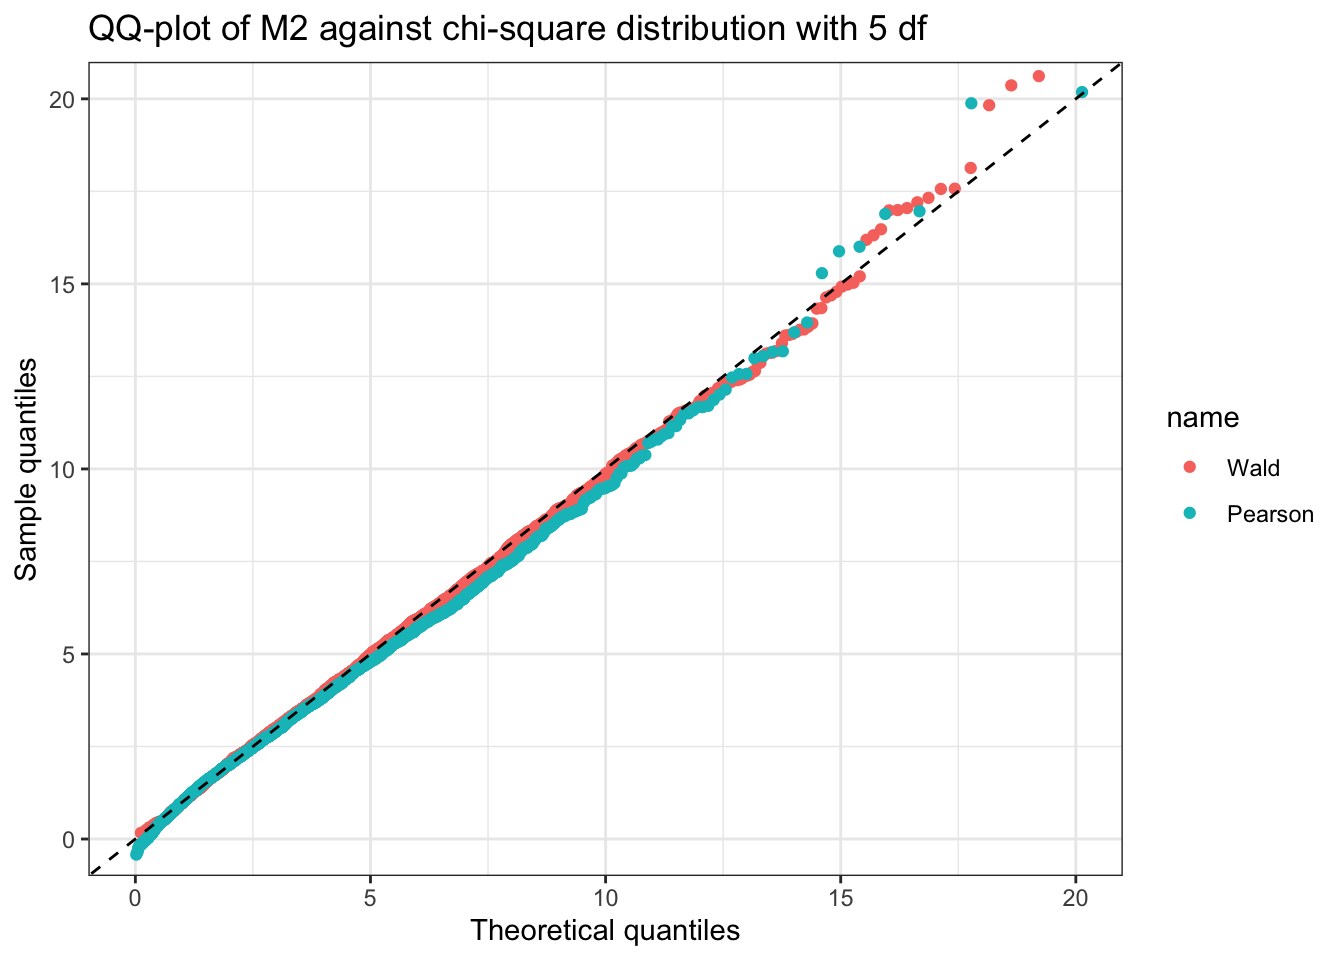

In [ ]:
bind_rows(res) |>
  mutate(
    df = mean(df),
    observed = sort(X2),
    expected = qchisq(ppoints(n()), df = df),
    .by = name
  ) |>
  ggplot(aes(expected, observed, col = name)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(
    title = "QQ-plot of M2 against chi-square distribution with 5 df",
    x = "Theoretical quantiles",
    y = "Sample quantiles"
  ) +
  coord_cartesian(xlim = c(0, 20), ylim = c(0, 20)) +
  theme_bw()

ℹ Please use `after_stat(density)` instead.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

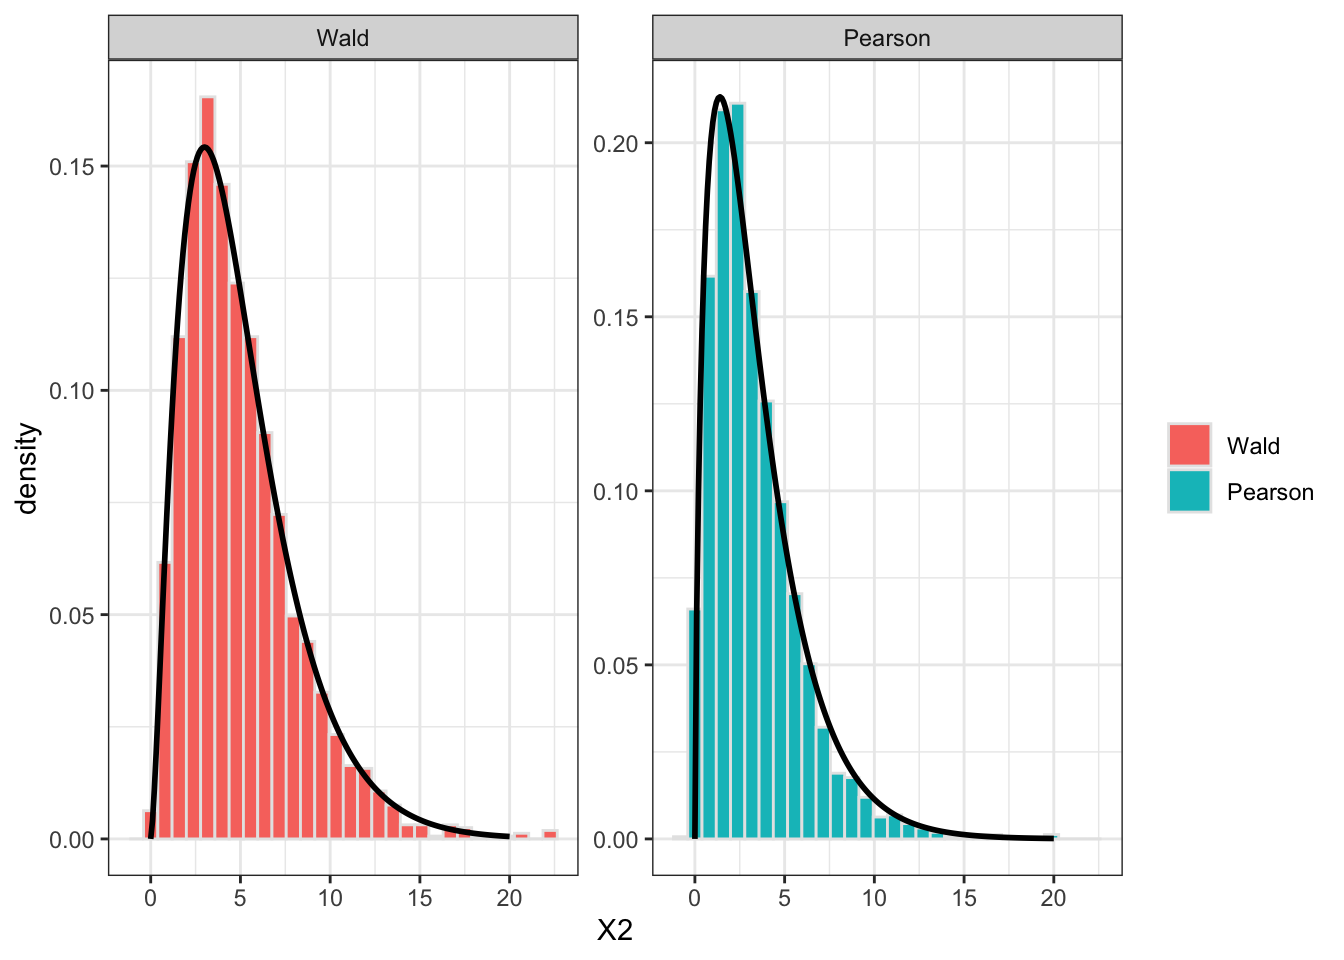

In [ ]:
bind_rows(res) |>
  ggplot(aes(x = X2, y = ..density.., fill = name)) +
  geom_histogram(col = "gray90") +
  geom_line(
    data = 
      bind_rows(res) |>
      group_by(name) |>
      summarise(df = mean(df), .groups = "keep") |>
      mutate(
        x = list(seq(0, 20, 0.1)),
        y = map(x, \(x) dchisq(x, df = first(df))),
        .groups = "drop"
      ) |>
      unnest(c(x, y)),
    aes(x, y),
    linewidth = 1
  ) +
  facet_wrap(name ~ ., scales = "free_y") + 
  labs(fill = NULL) +
  theme_bw()

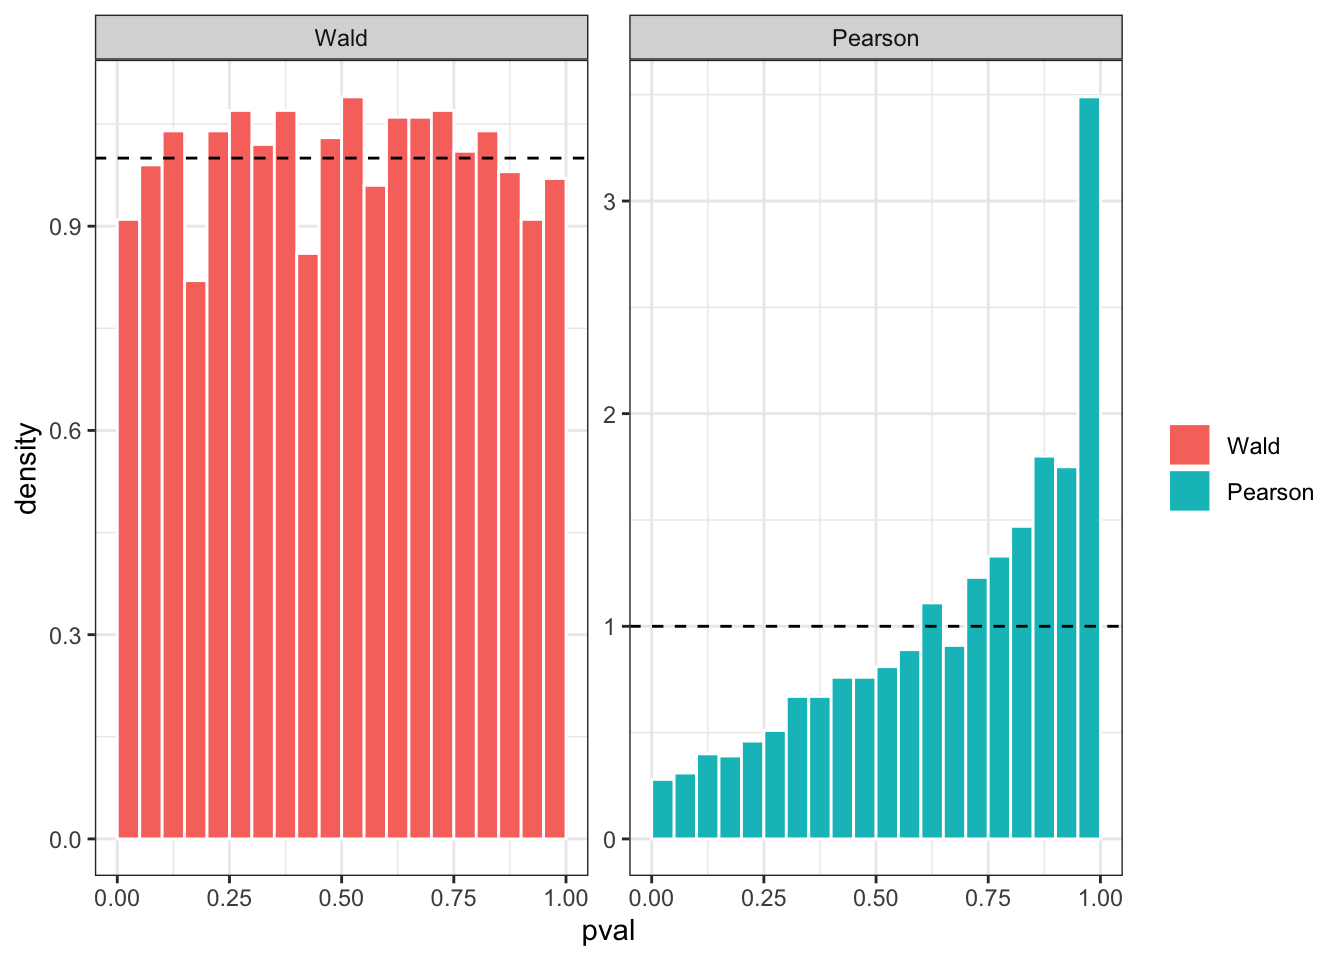

In [ ]:
bind_rows(res) |>
  ggplot(aes(x = pval, y = ..density.., fill = name)) +
  geom_histogram(binwidth = 0.05, boundary = 0, col = "white") +
  geom_hline(yintercept = 1, linetype = "dashed") +
  facet_wrap(name ~ ., scales = "free_y") + 
  labs(fill = NULL) +
  theme_bw()